In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import loading_tools
from JPAS_DA.data import cleaning_tools
from JPAS_DA.data import crossmatch_tools

import numpy as np
import os

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

In [2]:
root_path = global_setup.DATA_path
load_JPAS_x_DESI_Raul   = global_setup.load_JPAS_x_DESI_Raul
load_DESI_mocks_Raul    = global_setup.load_DESI_mocks_Raul
load_Ignasi             = global_setup.load_Ignasi

random_seed_load = global_setup.default_seed

In [3]:
DATA = loading_tools.load_data_bundle(
    root_path=root_path,
    include=["JPAS_x_DESI_Raul", "DESI_mocks_Raul", "Ignasi"],
    JPAS_x_DESI_Raul={"datasets": load_JPAS_x_DESI_Raul},
    DESI_mocks_Raul={"datasets": load_DESI_mocks_Raul},
    Ignasi={"datasets": load_Ignasi},
    random_seed=random_seed_load,
)

2025-09-30 13:45:57,092 - INFO - 📥 Starting modular dataset loading (load_data_bundle)
2025-09-30 13:45:57,092 - INFO - ├── Loading JPAS_x_DESI_Raul ...
2025-09-30 13:45:57,092 - INFO - ├─── 📥 Starting JPAS_x_DESI_Raul dataset loading...
2025-09-30 13:45:57,093 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-09-30 13:45:57,138 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-09-30 13:45:57,150 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-09-30 13:45:57,151 - WARNING - |    |    ⚠ No pickle file provided or file does not exist: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/DATA/JPAS_DATA_PROPERTIES_AUX.pkl
2025-09-30 13:45:57,151 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-09-30 13:45:57,152 - INFO - │   ✔ Loaded JPAS_x_DESI_Raul
2025-09-30 13:45:57,152 - INFO - ├── Loading DESI_mocks_Raul ...
2025-09-30 13:45:57,153 - INFO - ├─── 📥 Loading DESI 

In [4]:
print(DATA["Ignasi"]['all_pd'].keys())
print(DATA["JPAS_x_DESI_Raul"]['all_pd'].keys())
print(DATA["DESI_mocks_Raul"]['all_pd'].keys())

print(DATA["Ignasi"]['all_observations'].shape)
print(DATA["JPAS_x_DESI_Raul"]['all_observations'].shape)
print(DATA["DESI_mocks_Raul"]['all_observations'].shape)

dict_keys(['DESI_FLUX_G', 'DESI_FLUX_R', 'DESI_FLUX_Z', 'DESI_MAG_G', 'DESI_MAG_R', 'DESI_MAG_Z', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'HEALPIX', 'JPAS_DEC', 'JPAS_RA', 'MORPHTYPE', 'PROGRAM', 'SPECID', 'SPECTYPE', 'SUBTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'ZERR_DESI', 'ZWARN', 'Z_DESI', 'class', 'class_CBM', 'class_SQUEzE', 'class_TRANS', 'conf_SQUEzE_0', 'conf_SQUEzE_1', 'conf_SQUEzE_2', 'conf_SQUEzE_3', 'conf_SQUEzE_4', 'conf_gal', 'conf_gal_CBM', 'conf_gal_TRANS', 'conf_hqso', 'conf_hqso_CBM', 'conf_hqso_TRANS', 'conf_lqso', 'conf_lqso_CBM', 'conf_lqso_TRANS', 'conf_star', 'conf_star_CBM', 'conf_star_TRANS', 'is_in_desi_dr1', 'label_TRANS', 'match_sep_arcsec', 'z', 'z_SQUEzE_0', 'z_SQUEzE_1', 'z_SQUEzE_2', 'z_SQUEzE_3', 'z_SQUEzE_4', 'z_TRANS', 'z_err_TRANS', 'ALPHA_J2000', 'A_WORLD', 'B_WORLD', 'CLASS_STAR', 'DELTA_J2000', 'FLAGS', 'FWHM_WORLD', 'ISOAREA_WORLD', 'KRON_RADIUS', 'MAG_AUTO', 'MASK_FLAGS', 'R_EFF', 'Separation', '

In [5]:
# config_dict_cleaning = global_setup.config_dict_cleaning

config_dict_cleaning = {
    "mask_unreliable": {
        "enabled": True,
        "indices": [0, -2]
    },
    "nan": {
        "enabled": True,
        "keep_partial": True
    },
    "magic": {
        "enabled": True,
        "values": (-99, 99),
        "keep_partial": True
    },
    "selection": {
        "enabled": True,
        "i_band_sn_threshold": 200.0,
        "magnitude_flux_key": "DESI_FLUX_R",
        "magnitude_threshold": 22.5
    },
    "neg_errors": {
        "enabled": True
    },
    "qso_split": {
        "enabled": True,
        "z_lim_QSO_cut": 2.1,
        "spectype_key": "SPECTYPE",
        "redshift_key": "REDSHIFT",
        "redshift_key_fallback": "Z_DESI",
        "qso_label": "QSO",
        "low_label": "QSO_low",
        "high_label": "QSO_high"
    },
    "collapse": {
        "enabled": True,
        "positive_collapse_label": None,
        "spectype_key": "SPECTYPE",
        "negative_prefix": "no_"
    },
    "encoding": {
        "enabled": True,
        "shared_mappings": {
            "SPECTYPE":  {
                "QSO_high": 0,
                "QSO_low": 1,
                'GALAXY': 2,               
                'STAR': 3
            },
            "MORPHTYPE": {
                'DEV': 0,
                'EXP': 1,
                'GGAL': 2,
                'GPSF': 3,
                'PSF': 4,
                'REX': 5,
                'SER': 6,
                'nan': 7
            },
        }
    },
    "normalization": {
        "enabled": True,
        "file_path": os.path.join(global_setup.DATA_path, "norm_params.pkl"),
        "obs_key": "all_observations",
        "err_key": "all_errors",
        "pd_key": "all_pd",
        "suffix": "_normalized"
    }
}

In [6]:
DATA = cleaning_tools.clean_data_pipeline(DATA, config=config_dict_cleaning, in_place=True)

2025-09-30 13:46:20,437 - INFO - 🧹 Cleaning dataset: JPAS_x_DESI_Raul
2025-09-30 13:46:20,437 - INFO - ├── mask_out_unreliable_columns(mask_unreliable_filters_indices=[0, -2])
2025-09-30 13:46:20,447 - INFO - │   ├── Removed columns: [0, 55]
2025-09-30 13:46:20,447 - INFO - │   ├── New #filters: 55
2025-09-30 13:46:20,448 - INFO - │   ├── Updated observations shape: (52020, 55)
2025-09-30 13:46:20,448 - INFO - │   ├── Updated errors shape: (52020, 55)
2025-09-30 13:46:20,448 - INFO - ├── remove_NaNs(check='both', keep_rows_partially_filled_with_NaNs=True)
2025-09-30 13:46:20,449 - INFO - │   ├── rows fully NaN (drop): 0/52020 (0.00%)
2025-09-30 13:46:20,450 - INFO - │   ├── rows with SOME NaNs:   0/52020 (0.00%)
2025-09-30 13:46:20,450 - INFO - │   ├── rows dropped due to policy: 0/52020
2025-09-30 13:46:20,450 - INFO - │   └── final kept: 52020/52020 (100.00%)
2025-09-30 13:46:20,540 - INFO - ├── remove_magic_rows(check='obs', keep_rows_partially_filled_with_magic=True, magic_numbers=

In [7]:
print(DATA["Ignasi"].keys())
print(DATA["JPAS_x_DESI_Raul"].keys())
print(DATA["DESI_mocks_Raul"].keys())

print(DATA["Ignasi"]['all_pd'].keys())
print(DATA["JPAS_x_DESI_Raul"]['all_pd'].keys())
print(DATA["DESI_mocks_Raul"]['all_pd'].keys())

print(DATA["Ignasi"]['all_observations'].shape)
print(DATA["JPAS_x_DESI_Raul"]['all_observations'].shape)
print(DATA["DESI_mocks_Raul"]['all_observations'].shape)

dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['DESI_FLUX_G', 'DESI_FLUX_R', 'DESI_FLUX_Z', 'DESI_MAG_G', 'DESI_MAG_R', 'DESI_MAG_Z', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'HEALPIX', 'JPAS_DEC', 'JPAS_RA', 'MORPHTYPE', 'PROGRAM', 'SPECID', 'SPECTYPE', 'SUBTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'ZERR_DESI', 'ZWARN', 'Z_DESI', 'class', 'class_CBM', 'class_SQUEzE', 'class_TRANS', 'conf_SQUEzE_0', 'conf_SQUEzE_1', 'conf_SQUEzE_2', 'conf_SQUEzE_3', 'conf_SQUEzE_4', 'conf_gal', 'conf_gal_CBM', 'conf_gal_TRANS', 'conf_hqso', 'conf_hqso_CBM', 'conf_hqso_TRANS', 'conf_lqso', 'conf_lqso_CBM', 'conf_

In [8]:
Dict_LoA = {"intersection": {}, "outersection": {}}
IDs_only_DESI, IDs_only_JPAS, IDs_both, \
Dict_LoA["outersection"]["DESI_mocks_Raul"], Dict_LoA["outersection"]["JPAS_x_DESI_Raul"], \
Dict_LoA["intersection"]["DESI_mocks_Raul"], Dict_LoA["intersection"]["JPAS_x_DESI_Raul"] = crossmatch_tools.crossmatch_IDs_two_datasets(
    DATA["DESI_mocks_Raul"]['all_pd']['TARGETID'], DATA["JPAS_x_DESI_Raul"]['all_pd']['TARGETID']
)

2025-09-30 13:47:02,854 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-09-30 13:47:02,854 - INFO - ├── 🚀 Starting ID categorization process...
2025-09-30 13:47:02,912 - INFO - |    ├── 📌 Found 470645 unique IDs across 2 arrays.
2025-09-30 13:47:03,122 - INFO - |    ├── Presence matrix created with shape: (2, 470645)
2025-09-30 13:47:03,124 - INFO - |    ├── Category mask created with shape: (2, 470645)
2025-09-30 13:47:03,124 - INFO - ├── 🚀 Starting index retrieval process...
2025-09-30 13:47:03,124 - INFO - |    ├── 📌 Processing 470645 unique IDs across 2 arrays.
2025-09-30 13:47:03,332 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-09-30 13:47:03,341 - INFO - |    ├── Processing complete: 457437 IDs only in Array 1 (97.19%).
2025-09-30 13:47:03,341 - INFO - |    ├── Processing complete: 538 IDs only in Array 2 (0.11%).
2025-09-30 13:47:03,341 - INFO - |    ├── Processing complete: 12670 IDs in both arrays (2.69%).
2025-09-30 13:47:03,341 - INFO - ✅ 

In [9]:
print("=== Outersection ===")
print(f"DESI_mocks_Raul groups: {len(Dict_LoA['outersection']['DESI_mocks_Raul'])}")
print(f"DESI_mocks_Raul total IDs: {len(np.concatenate(Dict_LoA['outersection']['DESI_mocks_Raul']))}")
print()
print(f"JPAS_x_DESI_Raul groups: {len(Dict_LoA['outersection']['JPAS_x_DESI_Raul'])}")
print(f"JPAS_x_DESI_Raul total IDs: {len(np.concatenate(Dict_LoA['outersection']['JPAS_x_DESI_Raul']))}")

print("\n=== Intersection ===")
print(f"DESI_mocks_Raul groups: {len(Dict_LoA['intersection']['DESI_mocks_Raul'])}")
print(f"DESI_mocks_Raul total IDs: {len(np.concatenate(Dict_LoA['intersection']['DESI_mocks_Raul']))}")
print()
print(f"JPAS_x_DESI_Raul groups: {len(Dict_LoA['intersection']['JPAS_x_DESI_Raul'])}")
print(f"JPAS_x_DESI_Raul total IDs: {len(np.concatenate(Dict_LoA['intersection']['JPAS_x_DESI_Raul']))}")

=== Outersection ===
DESI_mocks_Raul groups: 457437
DESI_mocks_Raul total IDs: 1215688

JPAS_x_DESI_Raul groups: 538
JPAS_x_DESI_Raul total IDs: 538

=== Intersection ===
DESI_mocks_Raul groups: 12670
DESI_mocks_Raul total IDs: 36834

JPAS_x_DESI_Raul groups: 12670
JPAS_x_DESI_Raul total IDs: 12670


2025-09-30 13:47:03,607 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-09-30 13:47:03,608 - INFO - ├── 🚀 Starting ID categorization process...
2025-09-30 13:47:03,663 - INFO - |    ├── 📌 Found 470645 unique IDs across 2 arrays.
2025-09-30 13:47:03,868 - INFO - |    ├── Presence matrix created with shape: (2, 470645)
2025-09-30 13:47:03,870 - INFO - |    ├── Category mask created with shape: (2, 470645)
2025-09-30 13:47:03,870 - INFO - ├── 🚀 Starting index retrieval process...
2025-09-30 13:47:03,871 - INFO - |    ├── 📌 Processing 470645 unique IDs across 2 arrays.
2025-09-30 13:47:04,090 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-09-30 13:47:04,097 - INFO - |    ├── Processing complete: 538 IDs only in Array 1 (0.11%).
2025-09-30 13:47:04,097 - INFO - |    ├── Processing complete: 457437 IDs only in Array 2 (97.19%).
2025-09-30 13:47:04,098 - INFO - |    ├── Processing complete: 12670 IDs in both arrays (2.69%).
2025-09-30 13:47:04,098 - INFO - ✅ 

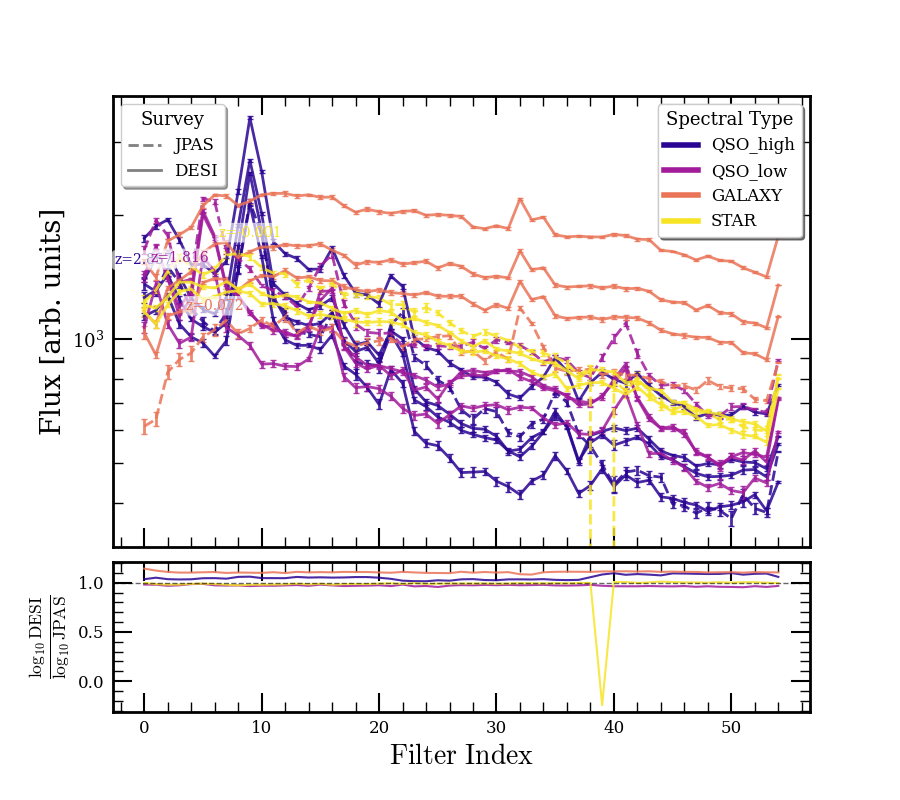

In [10]:
# --- Settings ---
survey_jpas = "JPAS_x_DESI_Raul"
survey_desi = "DESI_mocks_Raul"
NN = 1  # samples per spectral class

# --- Pull arrays we need
ids_jpas = np.asarray(DATA[survey_jpas]['all_pd']['TARGETID'])
ids_desi = np.asarray(DATA[survey_desi]['all_pd']['TARGETID'])

# --- Crossmatch to get intersection and per-ID indices
IDs_only_1, IDs_only_2, IDs_both, idxs_only_1, idxs_only_2, idxs_both_jpas, idxs_both_desi = (
    crossmatch_tools.crossmatch_IDs_two_datasets(ids_jpas, ids_desi)
)

# --- Build a quick lookup from TARGETID -> (indices in JPAS, indices in DESI)
id2idx = {}
for tid, ij, idesi in zip(IDs_both, idxs_both_jpas, idxs_both_desi):
    id2idx[tid] = {survey_jpas: np.atleast_1d(ij), survey_desi: np.atleast_1d(idesi)}

# --- Build the "matched JPAS" flat index list to choose samples by class
matched_JPAS_idx = np.concatenate(idxs_both_jpas) if len(idxs_both_jpas) else np.array([], dtype=int)

matched_SPECTYPE_int = np.asarray(DATA[survey_jpas]['all_pd']['SPECTYPE_int'])[matched_JPAS_idx]
matched_SPECTYPE_str = np.asarray(DATA[survey_jpas]['all_pd']['SPECTYPE'])[matched_JPAS_idx]
matched_TARGETID     = ids_jpas[matched_JPAS_idx]

# --- Unique classes (by integer code), and a stable string name per code
uniq_ints = np.unique(matched_SPECTYPE_int)
# map int code -> a representative string label (first seen)
int2label = {}
for u in uniq_ints:
    pos = np.flatnonzero(matched_SPECTYPE_int == u)
    int2label[int(u)] = str(matched_SPECTYPE_str[pos[0]]) if pos.size else f"class_{u}"

# --- Sample NN TARGETIDs per class (from the matched-JPAS subset)
rng = np.random.default_rng(0)
sampled_TARGETIDs = []
for code in uniq_ints:
    pos = np.flatnonzero(matched_SPECTYPE_int == code)
    if pos.size == 0:
        continue
    pick = rng.choice(pos, size=min(NN, pos.size), replace=False)
    sampled_TARGETIDs.append(matched_TARGETID[pick])
# shape ~ (n_classes, up to NN)
sampled_TARGETIDs = np.array(sampled_TARGETIDs, dtype=object)

# --- Plot setup (main + ratio)
fig, (ax, ax_ratio) = plt.subplots(
    2, 1, figsize=(9, 8), height_ratios=[3, 1], sharex=True, gridspec_kw={'hspace': 0.05}
)
ax.set_ylabel(r'Flux [arb. units]', fontsize=20)
ax_ratio.set_xlabel(r'$\mathrm{Filter~Index}$', fontsize=20)
ax_ratio.set_ylabel(r'$\frac{\log_{10}\mathrm{DESI}}{\log_{10}\mathrm{JPAS}}$', fontsize=18)

# Colors: one per spectral class
colors = plt.cm.plasma(np.linspace(0.05, 0.95, len(uniq_ints)))
linestyles = {survey_jpas: "--", survey_desi: "-"}

# --- Plot
label_lines_done = {survey_jpas: False, survey_desi: False}
ll = 0  # for staggered redshift text placement

for j, code in enumerate(uniq_ints):
    if j >= len(sampled_TARGETIDs):
        continue
    for k in range(len(sampled_TARGETIDs[j])):
        tid = sampled_TARGETIDs[j][k]
        if tid is None:
            continue
        # indices for this TARGETID in each dataset (use all occurrences)
        for key_survey in (survey_jpas, survey_desi):
            idxs = id2idx.get(tid, {}).get(key_survey, np.array([], dtype=int))
            for idx in np.atleast_1d(idxs):
                obs = np.asarray(DATA[key_survey]['all_observations'][idx], dtype=float)
                err = np.asarray(DATA[key_survey]['all_errors'][idx], dtype=float)
                z   = DATA[key_survey]['all_pd'].get('REDSHIFT', [np.nan])[idx]

                lbl = None
                if not label_lines_done[key_survey]:
                    lbl = "JPAS" if key_survey == survey_jpas else "DESI"
                    label_lines_done[key_survey] = True

                ax.errorbar(
                    np.arange(obs.size), obs, yerr=err,
                    capsize=2, lw=2.0, ls=linestyles[key_survey],
                    color=colors[j], ecolor=colors[j], alpha=0.85, label=lbl
                )

                # annotate redshift on JPAS curves
                if key_survey == survey_jpas and np.isfinite(z):
                    mid_idx = (ll % max(1, obs.size // 3)) * 3
                    mid_idx = min(mid_idx, obs.size - 1)
                    mid_y = obs[mid_idx] if np.isfinite(obs[mid_idx]) and obs[mid_idx] > 0 else np.nan
                    if np.isfinite(mid_y) and mid_y > 0:
                        ax.text(
                            mid_idx, mid_y * 1.1, f"z={z:.3f}",
                            fontsize=10, color=colors[j], ha='center', va='bottom',
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, boxstyle="round,pad=0.2")
                        )
                        ll += 1

        # ratio plot (use first occurrence in each)
        idxs_j = id2idx.get(tid, {}).get(survey_jpas, np.array([], dtype=int))
        idxs_d = id2idx.get(tid, {}).get(survey_desi, np.array([], dtype=int))
        if idxs_j.size and idxs_d.size:
            obs_j = np.asarray(DATA[survey_jpas]['all_observations'][idxs_j[0]], dtype=float)
            obs_d = np.asarray(DATA[survey_desi]['all_observations'][idxs_d[0]], dtype=float)
            # safe logs
            j_safe = np.log10(np.clip(obs_j, 1e-12, None))
            d_safe = np.log10(np.clip(obs_d, 1e-12, None))
            ratio = d_safe / np.where(j_safe == 0, np.nan, j_safe)
            ax_ratio.plot(np.arange(ratio.size), ratio, color=colors[j], ls="-", lw=1.5, alpha=0.85)

# Styling
ax.axhline(0, ls='--', lw=0.7, color='black', alpha=0.4)
ax.set_yscale("log")
ax.tick_params(axis='both', labelsize=13)
ax_ratio.axhline(1.0, ls='--', lw=1.0, color='black', alpha=0.6)
ax_ratio.tick_params(axis='both', labelsize=12)

# Legend for survey (linestyle)
survey_handles = [
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[survey_jpas], lw=2, label="JPAS"),
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[survey_desi], lw=2, label="DESI"),
]
leg0 = ax.legend(handles=survey_handles, loc='upper left', fancybox=True, shadow=True,
                 fontsize=12, title="Survey", title_fontsize=13)
ax.add_artist(leg0)

# Legend for spectral classes (colors)
spectype_handles = [
    mpl.lines.Line2D([0], [0], color=colors[j], lw=4, label=int2label[int(code)])
    for j, code in enumerate(uniq_ints)
]
leg1 = ax.legend(handles=spectype_handles, loc='upper right', fancybox=True, shadow=True,
                 fontsize=12, title="Spectral Type", title_fontsize=13)
ax.add_artist(leg1)

plt.tight_layout()
plt.show()

2025-09-30 13:50:28,338 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-09-30 13:50:28,338 - INFO - ├── 🚀 Starting ID categorization process...
2025-09-30 13:50:28,393 - INFO - |    ├── 📌 Found 470645 unique IDs across 2 arrays.
2025-09-30 13:50:28,599 - INFO - |    ├── Presence matrix created with shape: (2, 470645)
2025-09-30 13:50:28,600 - INFO - |    ├── Category mask created with shape: (2, 470645)
2025-09-30 13:50:28,601 - INFO - ├── 🚀 Starting index retrieval process...
2025-09-30 13:50:28,601 - INFO - |    ├── 📌 Processing 470645 unique IDs across 2 arrays.
2025-09-30 13:50:28,825 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-09-30 13:50:28,833 - INFO - |    ├── Processing complete: 538 IDs only in Array 1 (0.11%).
2025-09-30 13:50:28,833 - INFO - |    ├── Processing complete: 457437 IDs only in Array 2 (97.19%).
2025-09-30 13:50:28,833 - INFO - |    ├── Processing complete: 12670 IDs in both arrays (2.69%).
2025-09-30 13:50:28,834 - INFO - ✅ 

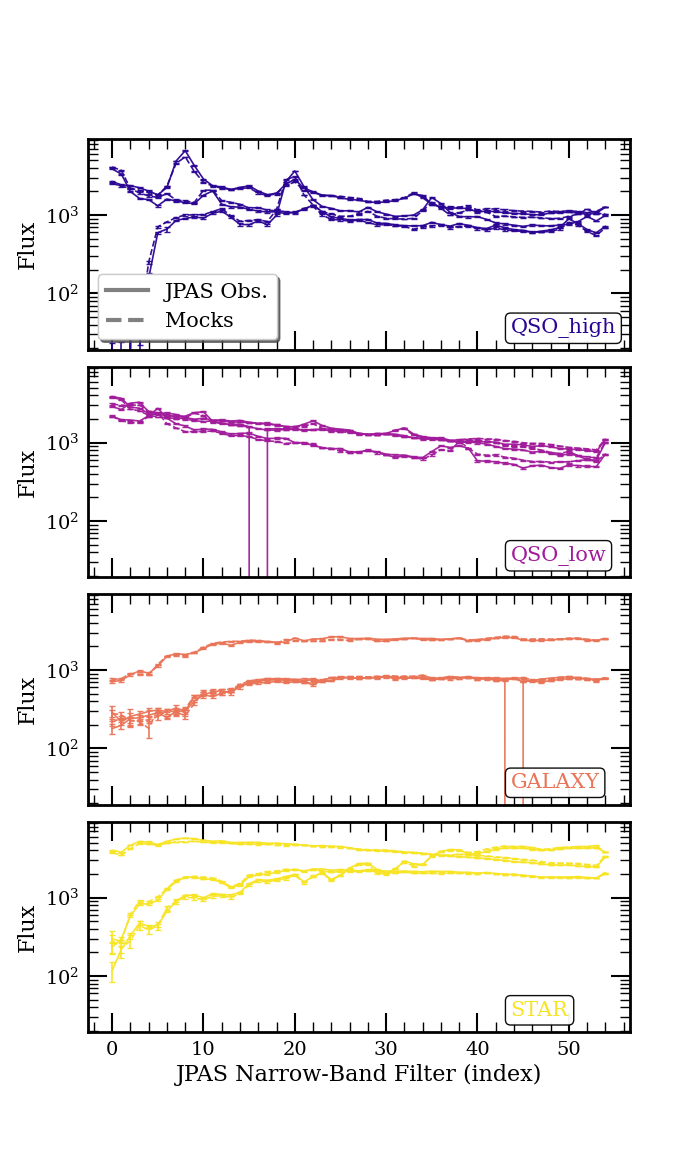

In [13]:
# --- Settings ---
survey_jpas = "JPAS_x_DESI_Raul"
survey_desi = "DESI_mocks_Raul"
NN = 3  # how many spectra per class to display

# Boxed class-label placement (axes fraction coords) and style
CLASS_BOX_XY = (0.78, 0.15)  # (x, y) in axes coords; top-left by default
CLASS_BOX_KW = dict(facecolor='white', alpha=0.95, edgecolor='k', boxstyle='round,pad=0.25')

# TargetID annotation style
TID_FONTSIZE = 7
TID_BOX_KW = dict(facecolor='white', alpha=0.2, edgecolor='none', boxstyle='round,pad=0.2')

# Fonts
FS_LABEL = 16
FS_TICKS = 14
FS_LEGEND = 15
FS_CLASS  = 15
FS_TITLE  = 16  # not used for per-axes .set_title (we use boxed labels instead)

# --- Pull arrays we need
ids_jpas = np.asarray(DATA[survey_jpas]['all_pd']['TARGETID'])
ids_desi = np.asarray(DATA[survey_desi]['all_pd']['TARGETID'])

# --- Crossmatch to get intersection and per-ID indices
IDs_only_1, IDs_only_2, IDs_both, idxs_only_1, idxs_only_2, idxs_both_jpas, idxs_both_desi = (
    crossmatch_tools.crossmatch_IDs_two_datasets(ids_jpas, ids_desi)
)

# --- Build a quick lookup from TARGETID -> (indices in JPAS, indices in DESI)
id2idx = {}
for tid, ij, idesi in zip(IDs_both, idxs_both_jpas, idxs_both_desi):
    id2idx[tid] = {survey_jpas: np.atleast_1d(ij), survey_desi: np.atleast_1d(idesi)}

# --- Build the "matched JPAS" flat index list to choose samples by class
matched_JPAS_idx = np.concatenate(idxs_both_jpas) if len(idxs_both_jpas) else np.array([], dtype=int)

matched_SPECTYPE_int = np.asarray(DATA[survey_jpas]['all_pd']['SPECTYPE_int'])[matched_JPAS_idx]
matched_SPECTYPE_str = np.asarray(DATA[survey_jpas]['all_pd']['SPECTYPE'])[matched_JPAS_idx]
matched_TARGETID     = ids_jpas[matched_JPAS_idx]

# --- Unique classes (by integer code), and a stable string name per code
uniq_ints = np.unique(matched_SPECTYPE_int)
int2label = {}
for u in uniq_ints:
    pos = np.flatnonzero(matched_SPECTYPE_int == u)
    int2label[int(u)] = str(matched_SPECTYPE_str[pos[0]]) if pos.size else f"class_{u}"

# --- Helper: sample UNIQUE TARGETIDs per class (up to NN)
rng = np.random.default_rng(1)
sampled_TARGETIDs = []
for code in uniq_ints:
    pos = np.flatnonzero(matched_SPECTYPE_int == code)
    if pos.size == 0:
        sampled_TARGETIDs.append(np.array([], dtype=object))
        continue

    tids_class = matched_TARGETID[pos]
    # de-duplicate TARGETIDs while preserving first-seen order
    _, first_idx = np.unique(tids_class, return_index=True)
    tids_unique = tids_class[np.sort(first_idx)]

    if tids_unique.size == 0:
        sampled_TARGETIDs.append(np.array([], dtype=object))
        continue

    pick_idx = rng.choice(tids_unique.size, size=min(NN, tids_unique.size), replace=False)
    sampled_TARGETIDs.append(tids_unique[pick_idx])
sampled_TARGETIDs = np.array(sampled_TARGETIDs, dtype=object)

# --- Plot setup: 1 row per class, shared x **and y** axes
n_classes = len(uniq_ints)
fig_h = max(3, 2.9 * n_classes)
fig, axes = plt.subplots(
    n_classes, 1, figsize=(7, fig_h), sharex=True, sharey=True, gridspec_kw={'hspace': 0.08}
)
if n_classes == 1:
    axes = np.array([axes])

# Colors: one per spectral class
colors = plt.cm.plasma(np.linspace(0.05, 0.95, n_classes))
linestyles = {survey_jpas: "-", survey_desi: "--"}

# Label each survey only once across all subplots
label_done = {survey_jpas: False, survey_desi: False}

# Track global y-range across ALL panels for common limits (log-scale safe)
tiny = 1e-12
global_min = np.inf
global_max = -np.inf

for j, (ax, code) in enumerate(zip(axes, uniq_ints)):
    tids_for_class = sampled_TARGETIDs[j] if j < len(sampled_TARGETIDs) else []
    ax.set_ylabel("Flux", fontsize=FS_LABEL)

    # Class label inside the panel (boxed text)
    label_text = f"{int2label[int(code)]}"
    ax.text(
        CLASS_BOX_XY[0], CLASS_BOX_XY[1], label_text,
        transform=ax.transAxes, ha='left', va='top',
        fontsize=FS_CLASS, color=colors[j], bbox=CLASS_BOX_KW
    )

    # counter to stagger TARGETID annotations across x
    ann_count = 0

    for tid in np.atleast_1d(tids_for_class):
        if tid is None:
            continue

        idxs_j = np.atleast_1d(id2idx.get(tid, {}).get(survey_jpas, np.array([], dtype=int)))
        idxs_d = np.atleast_1d(id2idx.get(tid, {}).get(survey_desi, np.array([], dtype=int)))
        if idxs_j.size == 0:
            continue  # nothing to plot

        # First occurrence only
        idx_j = idxs_j[0]
        obs_j = np.asarray(DATA[survey_jpas]['all_observations'][idx_j], dtype=float)
        err_j = np.asarray(DATA[survey_jpas]['all_errors'][idx_j], dtype=float)

        obs_d = err_d = None
        if idxs_d.size > 0:
            idx_d = idxs_d[0]
            obs_d = np.asarray(DATA[survey_desi]['all_observations'][idx_d], dtype=float)
            err_d = np.asarray(DATA[survey_desi]['all_errors'][idx_d], dtype=float)

        # DESI→JPAS scaling in flux space via mean(JPAS/DESI) over valid positives
        desi_scale = 1.0
        if obs_d is not None and obs_d.size == obs_j.size:
            valid = np.isfinite(obs_j) & np.isfinite(obs_d) & (obs_j > 0) & (obs_d > 0)
            if np.any(valid):
                desi_scale = float(np.mean(obs_j[valid] / np.clip(obs_d[valid], tiny, None)))

        # plot JPAS (flux)
        lbl_j = None if label_done[survey_jpas] else "JPAS"
        ax.errorbar(
            np.arange(obs_j.size), obs_j, yerr=err_j,
            capsize=2, lw=1.2, ls=linestyles[survey_jpas],
            color=colors[j], ecolor=colors[j], alpha=0.95, label=lbl_j
        )
        if lbl_j:
            label_done[survey_jpas] = True

        # plot DESI (flux, scaled)
        if obs_d is not None:
            obs_d_scaled = obs_d * desi_scale
            err_d_scaled = err_d * desi_scale if err_d is not None else None
            lbl_d = None if label_done[survey_desi] else "DESI (scaled)"
            ax.errorbar(
                np.arange(obs_d_scaled.size), obs_d_scaled, yerr=err_d_scaled,
                capsize=2, lw=1.2, ls=linestyles[survey_desi],
                color=colors[j], ecolor=colors[j], alpha=0.95, label=lbl_d
            )
            if lbl_d:
                label_done[survey_desi] = True

            # update global range with DESI too
            valid_d = np.isfinite(obs_d_scaled) & (obs_d_scaled > 0)
            if np.any(valid_d):
                global_min = min(global_min, float(np.min(obs_d_scaled[valid_d])))
                global_max = max(global_max, float(np.max(obs_d_scaled[valid_d])))

        # update global range with JPAS
        valid_j = np.isfinite(obs_j) & (obs_j > 0)
        if np.any(valid_j):
            global_min = min(global_min, float(np.min(obs_j[valid_j])))
            global_max = max(global_max, float(np.max(obs_j[valid_j])))

        # --- Annotate TARGETID near the JPAS curve, staggered across x
        # choose an x-index spaced across the wavelength/filter grid
        N = obs_j.size
        chunk = max(1, N // 4)  # roughly split into 4 segments
        mid_idx = min(ann_count * chunk + chunk // 2, N - 1)
        # find a nearby valid positive y for placement
        mid_idx_search = mid_idx
        for delta in range(0, min(10, N)):
            cand = mid_idx + (-1)**delta * (delta // 2)
            if 0 <= cand < N and np.isfinite(obs_j[cand]) and obs_j[cand] > 0:
                mid_idx_search = cand
                break
        y_val = obs_j[mid_idx_search]
        # place a bit above the point (works for log scale by multiplying)
        y_text = y_val * 1.15 if y_val > 0 else np.nan
        # if np.isfinite(y_text) and y_text > 0:
        #     ax.text(
        #         mid_idx_search, y_text, f"TID={int(tid)}",
        #         fontsize=TID_FONTSIZE, color=colors[j], ha='center', va='bottom',
        #         bbox=TID_BOX_KW
        #     )
        #     ann_count += 1

    ax.set_yscale("log")
    ax.tick_params(axis='both', labelsize=FS_TICKS)

# Apply shared x-label
axes[-1].set_xlabel("JPAS Narrow-Band Filter (index)", fontsize=FS_LABEL)

# Set common y-limits across all subplots (respect log scale)
if np.isfinite(global_min) and np.isfinite(global_max) and global_min > 0 and global_max > 0:
    y_lo = max(tiny, global_min / 1.4)
    y_hi = global_max * 1.4
    for ax in axes:
        ax.set_ylim(y_lo, y_hi)

# Survey legend (linestyles) – put it on the top panel
survey_handles = [
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[survey_jpas], lw=3, label="JPAS Obs."),
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[survey_desi], lw=3, label="Mocks"),
]
leg0 = axes[0].legend(handles=survey_handles, loc='lower left', fancybox=True, shadow=True,
                      fontsize=FS_LEGEND, title=None, title_fontsize=FS_LEGEND+1)
axes[0].add_artist(leg0)

plt.tight_layout()
plt.savefig(os.path.join(global_setup.path_saved_figures, "data_spectra.pdf"), format="pdf", bbox_inches="tight")
plt.show()
